# Accessing cloud satellite data

- Funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program
  
### Credits: Tutorial development
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute
* [Kylene Cooley](mailto:cooleyky@oregonstate.edu) - Oregon State University

### Satellite data

Satellite data come from either polar or low inclination orbits that circle the Earth or geostationary orbits that hold a location above a specific location on the Earth, near the Equator.  The type of data from satellites depends on both the orbit and the type of instrument.  There are definitions for the different satellite data types.
- L1 - satellite observations, usually each observation has a lat/lon/time associated with it
- L2 - derived geophysical retrievals (eg. SST), still with lat/lon/time
- L3 - variables mapped to a uniform space/time grid
- L4 - model output or analysis of data, may include multiple sensors

There are several different formats that satellite data:  [netCDF](https://www.unidata.ucar.edu/software/netcdf/), [HDF5](https://www.hdfgroup.org/solutions/hdf5/), and [geoTIFF](https://earthdata.nasa.gov/esdis/eso/standards-and-references/geotiff).
There are also som newer cloud optimized formats that data: [Zarr](https://zarr.readthedocs.io/en/stable/), Cloud Optimized GeoTIFF ([COG](https://www.cogeo.org/)).

### Understand the data
Data access can be easy and fast on the cloud, but to avoid potential issues down the road, spend time to understand the strengths and weaknesses of any data.  Any science results will need to address uncertainties in the data, so it is easier to spend time at the beginning to understand them and avoid data mis-application.

#### This tutorial will focus on netCDF/HDF5/Zarr

### Data proximate computing
These are BIG datasets that you can analyze on the cloud without downloading the data.  
You can run this on your phone, a Raspberry Pi, laptop, or desktop.   
By using public cloud data, your science is reproducible and easily shared!

### Here we will demonstrate some ways to access two different geostationary SST datasets on AWS:
- AWS GOES sea surface temperatures  (L2)
- AWS Himawari sea surface temperatures (L2 and L3)

### To run this notebook

Code is in the cells that have <span style="color: blue;">In [  ]:</span> to the left of the cell and have a colored background

To run the code:
- option 1) click anywhere in the cell, then hold `shift` down and press `Enter`
- option 2) click on the Run button at the top of the page in the dashboard

Remember:
- to insert a new cell below press `Esc` then `b`
- to delete a cell press `Esc` then `dd`

### First start by importing libraries


In [ ]:
# filter some warning messages
import warnings 
warnings.filterwarnings("ignore") 

#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


[fsspec.get_mapper](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_mapper#fsspec.get_mapper) Creates a mapping between your computer and the s3 bucket.  This isn't necessary if the Zarr file is stored locally.

[xr.open_zarr](http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html) Reads a Zarr store into an Xarray dataset


-----------------------------------------------------------
# How to find an AWS Public Dataset

- click here: [AWS Public Dataset](https://aws.amazon.com/opendata/)
- Click on `Find public available data on AWS` button
- Search for GOES
- Select [GOES-16 and GOES-17](https://registry.opendata.aws/noaa-goes/)



![](./goes.png)

------------------------------------------------------------



## NETCDF GEO DATA

- Info on the data is here -- GOES has a lot of different parameters and they are all stored in different files with names that are difficult to understand.  There are *80* different data products.  This link lists them all and explains the different directory names. [AWS info on GOES SST data](https://docs.opendata.aws/noaa-goes16/cics-readme.html).  

- The GOES data is netCDF format.  There is a different file for each of the 80 projects for year/day/hour.  A lot of files.  I find it really useful to 'browse' s3: buckets so that I can understand the directory and data structure.  [Explore S3 structure](https://noaa-goes16.s3.amazonaws.com/index.html).  The directory structure is `<Product>/<Year>/<Day of Year>/<Hour>/<Filename>`

- In the code below we are going to create a function that searches for all files from a certain day, then creates the keys to opening them.  The files are so messy that opening a day takes a little while.  There are other ways you could write this function depending on what your analysis goals are, this is just one way to get some data in a reasonable amount of time. 
- This function uses 
- [`s3fs.S3FileSystem`](https://s3fs.readthedocs.io/en/latest/) which holds a connection with a s3 bucket and allows you to list files, etc.  
- [`xr.open_mfdataset`](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset) opens a list of filenames and concatenates the data along the specified dimensions  

Website [https://registry.opendata.aws/noaa-goes/](https://registry.opendata.aws/noaa-goes/)


In [ ]:
def get_geo_data(sat,lyr,idyjl):
    # arguments
    # sat   goes-east,goes-west,himawari
    # lyr   year
    # idyjl day of year
    
    d = dt.datetime(lyr,1,1) + dt.timedelta(days=idyjl)
    fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

    #create strings for the year and julian day
    imon,idym=d.month,d.day
    syr,sjdy,smon,sdym = str(lyr).zfill(4),str(idyjl).zfill(3),str(imon).zfill(2),str(idym).zfill(2)
    
    #use glob to list all the files in the directory
    if sat=='goes-east':
        file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='goes-west':
        file_location,var = fs.glob('s3://noaa-goes17/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='himawari':
        file_location,var = fs.glob('s3://noaa-himawari8/AHI-L2-FLDK-SST/'+syr+'/'+smon+'/'+sdym+'/*/*L2P*.nc'),'sea_surface_temperature'
    
    #make a list of links to the file keys
    if len(file_location)<1:
        return file_ob
    file_ob = [fs.open(file) for file in file_location]        #open connection to files
    
    #open all the day's data
    ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time') #note file is super messed up formatting
    
    #clean up coordinates which are a MESS in GOES
    #rename one of the coordinates that doesn't match a dim & should
    if not sat=='himawari':
        ds = ds.rename({'t':'time'})
        ds = ds.reset_coords()
    else:
        ds = ds.rename({'ni':'x','nj':'y'})
    
    #put in to Celsius
    #ds[var] -= 273.15   #nice python shortcut to +- from itself a-=273.15 is the same as a=a-273.15
    #ds[var].attrs['units'] = '$^\circ$C'
   
    return ds


## Open a day of GOES-16  (East Coast) Data

In [ ]:
%%time
lyr, idyjl = 2020, 210  #may 30, 2020

ds = get_geo_data('goes-east',lyr,idyjl)

ds

In [ ]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)

masked.isel(time=14).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

In [ ]:
#%%time

#mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True

#mean_dy.plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

### Full Disc Image
This geostationary satellite records an hourly time series of a single disk-shaped view of the Earth. The next cells plot the mean of a 37-hour time slice for the entire spatial domain and a section of the Gulf Stream. 

In [4]:
masked_e = ds.where(ds.DQF==0) # selects only 'good quality' SST data
masked_e = masked_e.isel(time=slice(0,36)) # slice of first 37 hours of time series
masked_e = masked_e.SST.mean('time',skipna=True) # taking the mean in the time domain


gs_subset = ds.sel(x=slice(-0.012,0.012),y=slice(0.12,0.085))  # reduce to Gulf Stream region
masked_subset = gs_subset.SST.where(gs_subset.DQF==0) # 'good' data
masked_subset = masked_subset.isel(time=slice(0,36)) # time slice
masked_subset = masked_subset.mean('time')  # temporal mean

Plotting with Matplotlib.pyplot:

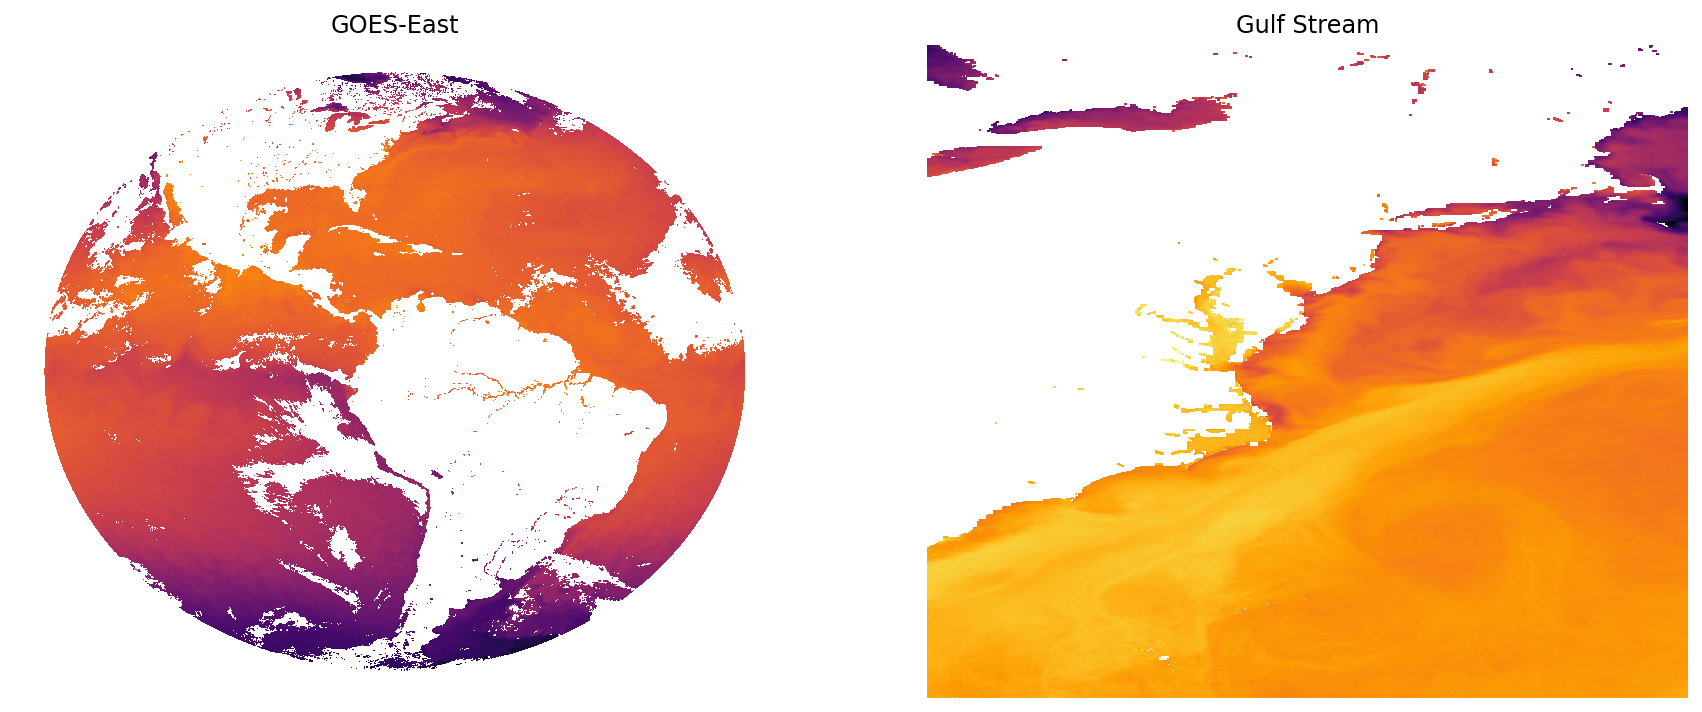

In [5]:
plt.ioff()


fig, ax = plt.subplots(1,2, figsize=(15,6))

masked_e.plot(ax=ax[0], cmap='inferno', add_colorbar=False)
ax[0].axis('off')

masked_subset.plot(ax=ax[1], cmap='inferno', add_colorbar=False)
ax[1].axis('off')

ax[0].set_title('GOES-East')
ax[1].set_title('Gulf Stream')

plt.show()

## Read AWS JMA Himawari SSTs
- define a function to get all the filenames for a day
- AWS info on Himawari SST data, [here](https://www.goes.noaa.gov/f_himawari-8.html)
- Explore S3 structure [here](https://noaa-himawari8.s3.amazonaws.com/index.html)
- SSTs are given in L2P and L3C GHRSST data formats.  
L2P has dims that not mapped to a regular grid.  
L3C is mapped to a grid, with dims lat,lon.

Website [https://registry.opendata.aws/noaa-himawari/](https://registry.opendata.aws/noaa-himawari/)


In [ ]:
#%%time
#lyr, idyjl = 2020, 212

#ds = get_geo_data('himawari',lyr,idyjl)

#subset = ds.sel(x=slice(-0.05,0.08),y=slice(0.12,0.08))

#masked = subset.sea_surface_temperature.where(subset.quality_level>=4)

#mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True

#mean_dy.plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')